# **Variational Auto-Encoders (VAEs) and the Evidence Lower-BOund (ELBO)**

### This practical



*   provides skeleton code for a VAE – you are tasked with filling in the missing bits and pieces
*   has a couple of experiments to visualize interesting/useful aspects of the VAE
*   is implemented using the python library [JAX](https://jax.readthedocs.io/en/latest/index.html)
*   will give a conceptual, rather than technical, introduction to the ELBO and variants thereof





### Before getting started, let us recap the VAE.

#### Background

VAE was simultaneously proposed by [Diederik P. Kingma and Max Welling](https://arxiv.org/abs/1312.6114) [1] and [Danilo Jimenez Rezende, Shakir Mohamed and Daan Wierstra](https://arxiv.org/abs/1401.4082) [2] independently. The former was published slightly prior to the latter, and has recieved considerably more citations. If you have not yet read/looked at either, I recommend checking out [1], as it will help you in this practical (and, of course, since it is a great piece of work).

Essentially, a VAE can be seen as a mapping from an input space to a latent (hidden or unobserved) space, then from the latent space to an output space. It consists of two parts, called encoder and decoder. With the help of encoder, we can map a given input sample $x_{ori} \sim p(x)$ to a distribution over the latent space. The distribution is denoted by $q_{\phi}(z|x_{ori})$ and $\phi$ denotes the parameters of the encoder (optimized via training), called ([variational](https://www.cs.jhu.edu/~jason/tutorials/variational.html)) parameters.

In mathematics, finding the best function (the distribution over the latent space in our case, i.e. $q_{\phi}(z|x_{ori})$) is done under the name of calculus of variations and this name also comes from that mathematical background. Variational approximation, (finding the best or closest function to a given function, in our case the true distribution over the latent sapce $p(z|x_{ori})$) is usually done because of the complexity of the original function (it means, it is hard to work with $p(z|x_{ori})$ because it has interactable terms).

So the idea of variational approximation is that to fix a family of distributions, say $Q$ (think of it as the set of all possible normal distributions $Q=\{\mathcal{N}(\mu,\sigma)| \mu \in \mathbb{R}, \sigma \in \mathbb{R}^+\}$), and then approximate a complex function, needless to say $p(z|x_{ori})$, with a simpler function $q_\phi(z|x_{ori}) \in Q$. To this end, we need to find the closest $q_\phi(z|x_{ori})$ to $p(z|x_{ori})$, and the parameters of $q_\phi(z|x_{ori})$ (in our example, a good $\mu$ and $\sigma$) are called **variational parameters**. The subscript $\phi$, also called variational paramters or encoder paramters, denotes that the distribution we get, depends on some other variables that has to be optimized (i.e. the variables that we use to map a given input $x$ to a distribution over the latent space, for example $\phi=\{W_1,W_2,b_1,b_2\}$ if we are using a two layer MLP).

Note that $q_\phi(z|x)$ is a function of two variables both $x$ and $z$ and when you plug in some specific $x$, you still have a function of $z$.  Therefore, $q_\phi(z|x)$ gives us the paramters of a distribution (in our example it gives us some specific $\mu$ and $\sigma$ after plugging it $x$). Then, after getting the paramters of a distribution over the latent space $q_\phi(z|x_{ori})$, it is time to reconstruct the input sample $x_{ori}$ from its latent representation $q_\phi(z|x_{ori})$, but the problem is that we can not use a function as input into the decoder! So what we can do is to draw (several) samples from the latent distribution $q_\phi(z|x_{ori})$ and recover a distribution over the  input space. Another the problem is that it is that, sampling is not differentiable, making our model indifferentiable. To see why, try to diffrentiate a sample drawn from a Normal distribution, i.e. while $x \sim \mathcal{N}(\mu,\sigma)$ try to compute the following:
$$
\frac{dx}{d\mu}
$$

To solve the problem regarding the sampling and indifferentiability, [1] have proposed a trick called **reparameterization trick**, of which you'll hear more in the rest of this practical. But for now, it suffices to assume that we know we can use a sample like $z_{ori} \sim q_\phi(z|x_{ori})$, to map it back to the input sapce again, using a decoder, or so called **the generative** model. In our example, it is as simple as $z_{ori} \sim \mathcal{N}(\mu_{ori},\sigma_{ori})$ where the $\mu_{ori}$ and $\sigma_{ori}$ is obtained simply by plugging in $x_{ori}$ into the encoder, i.e. $q_\phi(z|x_{ori})$.

As the decoder is acting on samples of a distribution, and becomes stochastic by virtue of sampling, it defines a distribution over the input space. Therefore, the **distribution recovered** from $z_{ori}$ by the decoder, is denoted by $p_\theta(x|z_{ori})$.

The $\theta$ subscript is the parameters of the generative model, also called generative paramters are optimized jointly with $\phi$. Finally, we can *decode* $z_{ori}$ by sampling from $p_{\theta}(x|z_{ori})$. The decoding of $z_{ori}$, i.e. $x_{rec}\sim p_{\theta}(x|z_{ori})$, is commonly referred to as the *reconstruction*.

Note that in the original paper you do not see any distinction between $x_{ori}$, $x_{rec}$ and $x$ as they are in the same space, but it is added here to make it easy to explain the idea! Following [1], we avoid the use of subscripts in the rest of the practical.

### Why?
There are plenty of interesting tasks that can be tackled using VAEs. Some important examples include dimensionality reduction (encoding $x$ as $z$, such that dim($z$) < dim($x$)), noise filtering (a.k.a. reconstructing the input), generating synthetic data (sampling from $p_{\theta}(x|z)$) and density estimation. Let us zoom in on the latter.

Say we are interested in learning the posterior distribution $p(z|x)$ for whatever reason. In most interesting scenarios, however, we cannot learn it since it is intractable. The intractability of

$$
  p(z|x) = \frac{p(z,x)}{p(x)}
$$

stems from not being able to compute $p(x) = \int p(z, x) dz$ as it involves marginalizing over all $z$. Instead of learning $p(z|x)$ directly, we have to approximate it.



### How?
The VAE is a form of (amortized) variational inference (VI). In VI we approximate the intractable posterior using a simpler distribution, $q_{\phi}(z|x)$, inferring $\phi$ by estimating the marginal log-likelihood, $\log p(x)$. Consequently, we actually estimate two densities.

The inference is performed by *maximizing* the **E**vidence **L**ower **BO**ound (ELBO in short), $\mathcal{L}$:

$$\mathbb{E}_{q_{\phi}(z|x)}\left[\log\frac{p(z, x)}{q_{\phi}(z|x)}\right] \triangleq \mathcal{L} = - D_{KL}(q_{\phi}(z|x)||p(z)) +\mathbb{E}_{q_{\phi}(z|x)}\left[\log p_\theta(x|z)\right]$$

where $D_{KL}(q_{\phi}(z|x)||p(z))$ is the Kullback-Leibler (KL) divergence. The KL divergence is strictly non-negative, and zero if and only if $q_{\phi}(z|x) = p(z)$, while the marginal log-likelihood, $\log p(x)$, is a constant. It is also possible to write:

$$\log p(x) = D_{KL}(q_{\phi}(z|x)||p(z|x)) + \mathcal{L}$$
The $D_{KL}(q_{\phi}(z|x)||p(z|x))$ term is called **the variational gap** and is non-negative, so it can be seen that we have:
$$\log p(x) \geq \mathcal{L}$$

Therefore, the ELBO is a lower bound on the marginal log-likelihood and maximizing $\mathcal{L}$ indirectly minimizes $D_{KL}(q_{\phi}(z|x)||p(z|x))$ (which we do not have), giving us a better approximation of the intractable posterior.  See [1] for the derivation.
Note that the negated ELBO is often referred to as the negative log-likelihood (NLL).

In this practical, as in [1], we will assume that $q_\phi(z|x) = \mathcal{N}(z;\mu,\sigma^2)$, $p(z)=\mathcal{N}(0,1)$ and $p_{\theta}(x|z) = \text{Bernoulli}(x;θ$). Hence we can evaluate all terms in the ELBO, where $p(z,x) = p_\theta(x|z)p(z)$.

### Benchmarking VAEs in Density Estimation Tasks
This will be a recurring topic in this practical. Namely, you may train on whichever objective function you deem fitting, however when reporting your results in order to compare the performance of your algorithm, the evaluation of the **correct** objective is crucial. For instance, if you want to compare your VAE's NLL scores with others', then make sure the objective function is in fact a lower-bound on the marginal log-likelihood. More on that later.

## VAE in JAX
Now, let's import the necessary libraries. Feel free to add imports as you wish.

In [22]:
import os
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
from tensorflow_probability.substrates import jax as tfp
import jax
import jax.numpy as jnp
from jax import jit, grad, lax, random
from jax.example_libraries import optimizers
from jax.example_libraries import stax
from jax.example_libraries.stax import Dense, FanOut, Relu, Softplus, Sigmoid
import numpy as np
from torch.utils import data
from torchvision.datasets import MNIST, FashionMNIST
from functools import partial

# IMPORTANT NOTE:
# if you have got a NaN loss and/or have trouble debugging. Then, set
# jax_disable_jit to True. This will help you print out the variables.
jax.config.update('jax_disable_jit', False)

For the sake of simplicity, we use the MNIST dataset in this practical.

The next cell creates a PyTorch dataloader. Using either PyTorch or TensorFlow dataloaders seems to (currently) be the practice when working with JAX. The code has been slighlty altered after being copying from [here](https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/Neural_Network_and_Data_Loading.ipynb#scrollTo=94PjXZ8y3dVF).

In [23]:
def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

In [24]:
batch_size = 248
# Define our dataset, using torch datasets
mnist_dataset = MNIST('/tmp/mnist/', download=True, transform=FlattenAndCast())
training_generator = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)
mnist_dataset_test = MNIST('/tmp/mnist/', download=True, train=False)
test_images = jnp.array(mnist_dataset_test.test_data.numpy().reshape(len(mnist_dataset_test.test_data), -1), dtype=jnp.float32)
test_labels = jnp.array(mnist_dataset_test.test_labels)

/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### Initializing the Network and Optimizer

Next we put together a simple VAE, using two-layered MLPs with 300 hidden units for both the encoder and decoder networks. Note that the two parallel ultimate layers in the encoder net output latent_dimensions-dimensional arrays. **Based on the respective ranges of these two outputs, which one is $\mu$ and which is $\sigma$?** The second one is sigma.

Also, note that we apply **the sigmoid function on the outputs of the decoder**. Recall that $p_\theta(x|z)$ models the paramters of a Bernoulli distribution.

Initialize the networks and the Adam optimizer.

In [25]:
latent_dimensions = 2

# encoder defs
encoder_init, encode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    FanOut(2),
    stax.parallel(Dense(latent_dimensions), stax.serial(Dense(latent_dimensions), Softplus)),
)

# decoder defs
decoder_init, decode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    Dense(28 * 28), Sigmoid
)


# initialize networks and get params
enc_init_key, dec_init_key = random.split(random.PRNGKey(100))
_, encoder_params = encoder_init(enc_init_key, input_shape=(-1, 28 * 28))
_, decoder_params = decoder_init(dec_init_key,
                                 input_shape=
                                 (-1, latent_dimensions))
params = encoder_params, decoder_params

# initialize optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=0.0001)
opt_state = opt_init(params)

### Task 1: Reparameterization Trick
See [1] to figure out what **reparameterization trick** is, and implement the reparameterization trick in the following function.

In [26]:
def sample(rng, mu, std):
  # use the reparameterization trick
  # TODO
  rng,key = random.split(rng)
  gaussian = random.normal(key, shape=mu.shape)
  z = mu + gaussian * std
  return z

Continuing with the VAE pipeline. "@jit" is a JAX decoration which apparently heavily speeds up operations. Beware, however, that it does not support all operations, putting restrictions on the function it decorates.

In [27]:
@jit
def forward(params, x, rng):
    encoder_params, decoder_params = params
    phi = encode(encoder_params, inputs=x)
    z = sample(rng, mu=phi[0], std=phi[1])
    bernoulli_theta = decode(decoder_params, z)
    return phi, z, bernoulli_theta

### Task 2: ELBO
**Compute the ELBO in the following function.** Feel free to add or remove input arguments, except for params; params should be the first input argument (it's due to how JAX computes gradients). Also, since the optimizer *minimizes* the objective function, make sure to return the negated ELBO. Hint: recall the definition of the ELBO, note that it can be Monte Carlo approximated as follows

$\mathcal{L} = \mathbb{E}_{q_\phi(z|x)}\left[ \log\frac{p_\theta(x|z)p(z)}{q_\phi(z|x)} \right] \simeq \frac{1}{L}\sum_l \log\frac{p_\theta(x|z_l)p(z_l)}{q_\phi(z_l|x)}$,

and, following [1], let $L=1$.

Finally, package `tfp.distributions` could be used to calculate the (log) probability of different distributions. For instance, we could use `tfp.distributions.Bernoulli` to compute the likelihood of the pixels.

In [28]:
@jit
def get_elbo(params, x, rng):
    # the negative elbo should be a scalar value, i.e. averaged over the mini-batch.
    (mu,sigma), z, bernoulli_theta = forward(params, x, rng)
    sigma = sigma + 1e-6
    # TODO: write code to compute the ELBO
    p_theta = tfp.distributions.Bernoulli(probs=bernoulli_theta)
    p = tfp.distributions.Normal(loc=jnp.zeros_like(mu), scale=jnp.ones_like(sigma))
    q = tfp.distributions.Normal(loc=mu, scale=sigma)

    p_theta_log = (p_theta.log_prob(x)).sum(-1)
    p_log = (p.log_prob(z)).sum(-1)
    q_log = (q.log_prob(z)).sum(-1)

    elbo = jnp.mean(p_theta_log + p_log - q_log)

    return -elbo

Now to the training and evaluation steps. Note that we have normalized the pixel values in order for them to fit the probabilistic model.

In [29]:
def epoch_step(epoch, training_generator, opt_state):
    # an rng, random number generator, is required for all stochastic operations
    rng = random.PRNGKey(epoch)
    nlls = []
    for i, (x, y) in enumerate(tqdm(training_generator)):
        x = jax.device_put(x) / 255.0

        value, grads = jax.value_and_grad(get_elbo)(get_params(opt_state), x, rng)
        opt_state = opt_update(i, grads, opt_state)

        nlls.append(value)
    return opt_state, np.mean(nlls)

Luckily, the complete test set fits in the memory, and so we can compute the average NLL on all images at once without taking the batch size into account. This might not always be possible, in which case you must be careful regarding how you average the NLL scores, since all batches needn't be of the same size. Failing to do so will make your NLL scores unfit for benchmarking.

In [30]:
def evaluate(opt_state, x, test_rng):
    params = get_params(opt_state)
    x = jax.device_put(x) / 255.0
    nll = get_elbo(params, x, test_rng)
    return nll

**Plot the NLL vs. epochs curves (train and test) and see that they're decaying.**

Epoch:  0


100%|██████████| 242/242 [00:20<00:00, 11.92it/s]


Train NLL: 303.78509521484375
Test NLL:  214.61609 

Epoch:  1


100%|██████████| 242/242 [00:19<00:00, 12.66it/s]


Train NLL: 210.38858032226562
Test NLL:  205.69542 

Epoch:  2


100%|██████████| 242/242 [00:16<00:00, 14.81it/s]


Train NLL: 202.87109375
Test NLL:  198.1742 

Epoch:  3


100%|██████████| 242/242 [00:16<00:00, 14.67it/s]


Train NLL: 196.39849853515625
Test NLL:  193.50781 

Epoch:  4


100%|██████████| 242/242 [00:17<00:00, 13.89it/s]


Train NLL: 192.763427734375
Test NLL:  190.58823 

Epoch:  5


100%|██████████| 242/242 [00:16<00:00, 14.89it/s]


Train NLL: 190.2578125
Test NLL:  188.36191 

Epoch:  6


100%|██████████| 242/242 [00:18<00:00, 13.42it/s]


Train NLL: 188.2336883544922
Test NLL:  186.57283 

Epoch:  7


100%|██████████| 242/242 [00:16<00:00, 14.81it/s]


Train NLL: 186.64491271972656
Test NLL:  185.1725 

Epoch:  8


100%|██████████| 242/242 [00:16<00:00, 14.92it/s]


Train NLL: 185.3138885498047
Test NLL:  183.92082 

Epoch:  9


100%|██████████| 242/242 [00:18<00:00, 13.14it/s]


Train NLL: 184.09719848632812
Test NLL:  182.50914 

Epoch:  10


100%|██████████| 242/242 [00:16<00:00, 14.79it/s]


Train NLL: 182.76513671875
Test NLL:  180.97337 

Epoch:  11


100%|██████████| 242/242 [00:16<00:00, 14.36it/s]


Train NLL: 181.28408813476562
Test NLL:  179.51294 

Epoch:  12


100%|██████████| 242/242 [00:16<00:00, 14.24it/s]


Train NLL: 180.01290893554688
Test NLL:  178.30238 

Epoch:  13


100%|██████████| 242/242 [00:16<00:00, 15.00it/s]


Train NLL: 178.96409606933594
Test NLL:  177.37802 

Epoch:  14


100%|██████████| 242/242 [00:17<00:00, 13.90it/s]


Train NLL: 178.10397338867188
Test NLL:  176.60994 

Epoch:  15


100%|██████████| 242/242 [00:16<00:00, 14.81it/s]


Train NLL: 177.39553833007812
Test NLL:  175.99652 

Epoch:  16


100%|██████████| 242/242 [00:16<00:00, 14.80it/s]


Train NLL: 176.8094940185547
Test NLL:  175.46211 

Epoch:  17


100%|██████████| 242/242 [00:17<00:00, 13.85it/s]


Train NLL: 176.29071044921875
Test NLL:  175.0214 

Epoch:  18


100%|██████████| 242/242 [00:16<00:00, 15.03it/s]


Train NLL: 175.78695678710938
Test NLL:  174.57246 

Epoch:  19


100%|██████████| 242/242 [00:16<00:00, 14.62it/s]


Train NLL: 175.29364013671875
Test NLL:  174.1376 



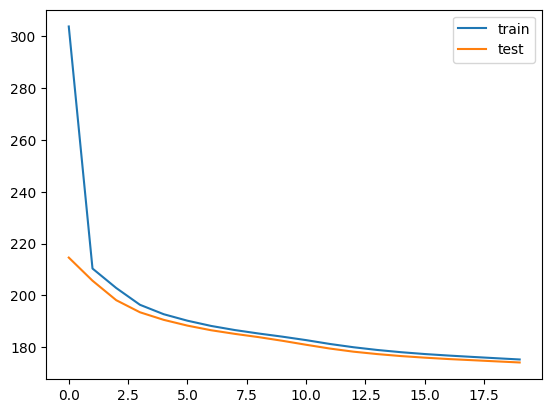

In [ ]:
n_epochs = 20
test_key = random.PRNGKey(100)
test_loss = []
train_loss = []
for epoch in range(n_epochs):
    print("Epoch: ", epoch)
    key, test_key = random.split(test_key)
    opt_state, nll_train = epoch_step(epoch, training_generator, opt_state)
    nll_test = evaluate(opt_state, test_images, test_key)
    test_loss.append(nll_test)
    train_loss.append(nll_train)
    print(f"Train NLL: {nll_train}")
    print("Test NLL: ", nll_test, '\n')

plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.show()

### Task 3: Experiments

Let's put the trained VAE to use by visulizing the latent space and sampling synthetic data. Complete the following code snippets to do so.
**Visualize the latent space. Use the labels $y$ to color the latent representations in a scatter plot.**

Hint: Encode the training or test set, and use `plt.scatter`.

In [31]:
def show_latent_space(rng):
  params = get_params(opt_state)
  (mu, sigma), z, _ = forward(params, test_images, rng)

  plt.figure(figsize=(10, 8))
  scatter = plt.scatter(z[:, 0], z[:, 1], c=test_labels,cmap='tab10', alpha=0.7)
  plt.colorbar(scatter, label='Digit Class')
  plt.xlabel('Latent Dimension 1')
  plt.ylabel('Latent Dimension 2')
  plt.title('Latent representation')
  plt.grid(True, alpha=0.3)
  plt.show()
  pass

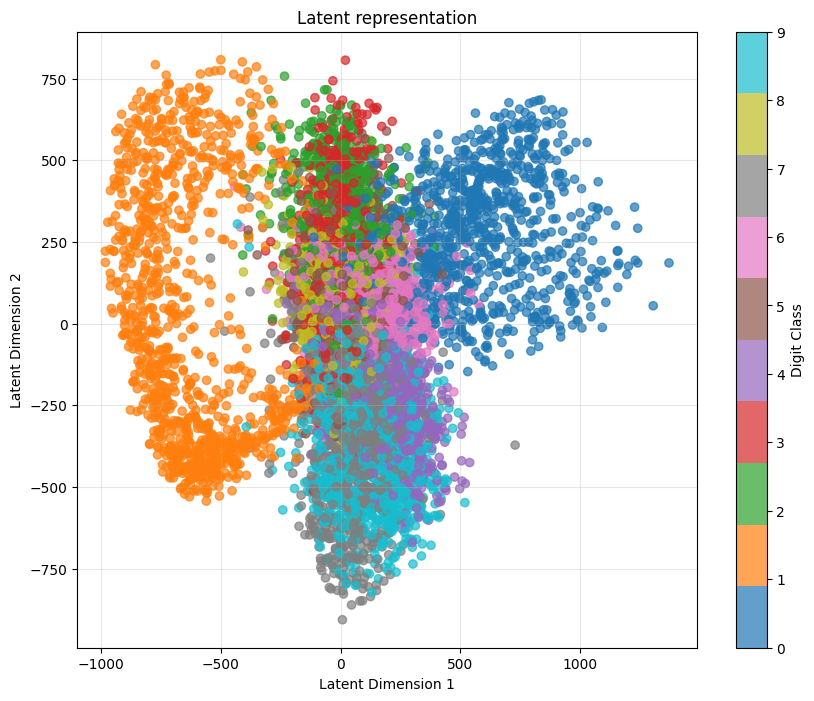

In [ ]:
show_latent_space(rng=random.PRNGKey(0))

Monitor the reconstruction quality of your model. Visualize a single input image together its reconstruction.

In [96]:
def reconstruct_an_image(rng):
    x = test_images[3]  # the image to be reconstructed
    params = get_params(opt_state)

    (mu, sigma), z, bernoulli_theta = forward(params, x, rng)
    reconstructed = bernoulli_theta

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(x.reshape(28, 28), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.reshape(28, 28), cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return


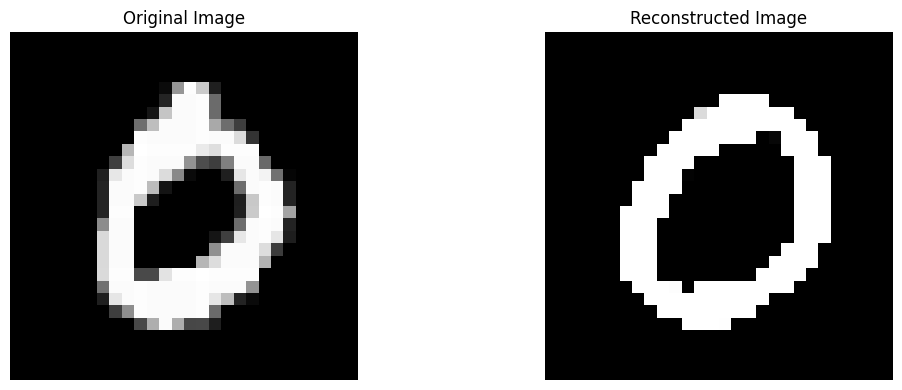

In [ ]:
reconstruct_an_image(rng=random.PRNGKey(0))

**Generate synthetic data.** Hint: sample $z\sim p(z)$ or "walk" in the latent space. Decode the $z$ you sample/visit and plot the decoded image. Think about what output you expect when you sample from 1) a Bernoulli distribution, or 2) regard the Bernoulli parameter as the sample.

In [97]:
@jit
def sample_image(rng,sample_image):
    # feel free to add other args to the function
    # either sample from the prior, or walk/do a grid search over z's
    params = get_params(opt_state)
    rng, key = random.split(rng)
    z_sample = random.normal(key, shape=(1,latent_dimensions))
    sampled_image = decode(params[1], z_sample)
    return sampled_image


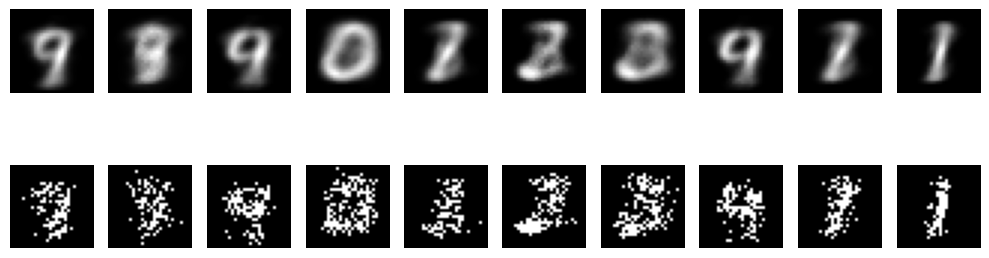

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 4))
rng = random.PRNGKey(1000)

for i in range(10):
    rng, key = random.split(rng)
    sampled_image = sample_image(key)

    axes[0, i].imshow(sampled_image.reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')

    rng, key = random.split(rng)
    sampled_bernoulli = random.bernoulli(key, sampled_image)

    axes[1, i].imshow(sampled_bernoulli.reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## $\beta$-VAE

The $\beta$-VAE was proposed by [Higgins et al.](https://openreview.net/pdf?id=Sy2fzU9gl) in 2017 and is a straightforward but important extension of the VAE. In terms of architecture, $\beta$-VAE and VAE are indistinguishable. In fact, the novelty in the work by Higgins et al. lies in a minor modification of the ELBO objective, the $\beta$-objective

$\mathcal{L}_\beta = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - \beta \mathbb{E}_{q_\phi(z|x)}[\log \frac{q_\phi(z|x)}{p(z)}]$,

where $\beta\geq0$ is a hyperparameter weighting the KL divergence

KL$(q_\phi(z|x)\Vert p(z)) = \mathbb{E}_{q_\phi(z|x)}[\log \frac{q_\phi(z|x)}{p(z)}]$. Observe that we retrieve the standard ELBO when $\beta=1$.

This objective is useful for

* emphasizing high-fidelity reconstructions *or* disentangling the latent space
* obtaining an increased interpretability
* doing KL warm-up.

The effects of the $\beta$-objective are mostly visible asymptotically, why we may not experience the full power of it here (e.g., [NVAE](https://arxiv.org/pdf/2007.03898.pdf) applies KL warm-up during the *first 25k iterations*).

However, plenty of the state-of-the-art VAEs (in terms of density estimation) apply KL warm-up (e.g. NVAE, [VampPrior](https://arxiv.org/pdf/1705.07120.pdf), [LadderVAE](https://arxiv.org/pdf/1602.02282.pdf); see LadderVAE for a nice motivation of KL warm-up), so it is good to know. Also, aside from being very straightforward to implement, the $\beta$-objective leads us to the following important note.

**Important note**: as pointed out by [Hoffman et al.](http://bayesiandeeplearning.org/2017/papers/66.pdf), the $\beta$-objective shown above cannot be considered an evidence lower-bound. Hence, test scores based on the $\beta$-objective **should not be used for benchmarking against proper marginal log-likelihood estimates (such as the ELBO)**. If you are interested, try to reverse the derivations of the ELBO in [1] while including $\beta$.

### Task 4: $\beta$-ELBO

**Compute the $\beta$-objective in the following function.**

Hint: this should require minimal changes to the ```get_elbo```
function above. Also, observe that



$\mathcal{L}_\beta \simeq \frac{1}{L}\sum_l \log p_\theta(x|z_l)-\beta\log\frac{q_\phi(z_l|x)}{p(z_l)}$.


In [34]:
@jit
def get_beta_elbo(params, x, rng, beta):
    # the negative elbo should be a scalar value, i.e. averaged over the mini-batch.
    (mu, sigma), z, bernoulli_theta = forward(params, x, rng)
    # write code to compute the ELBO
    p_theta = tfp.distributions.Bernoulli(probs=bernoulli_theta)
    p = tfp.distributions.Normal(loc=0, scale=1)
    q = tfp.distributions.Normal(loc=mu, scale=sigma)

    p_theta_log = (jnp.sum(p_theta.log_prob(x), axis=-1))
    p_log = (jnp.sum(p.log_prob(z), axis=-1))
    q_log = jnp.sum(q.log_prob(z), axis=-1)

    beta_elbo = jnp.mean(p_theta_log - beta*(q_log- p_log))

    return -beta_elbo

Now we define ```epoch_step_beta``` that calls ```get_beta_elbo``` instead of ```get_elbo```, and so that it can take a $\beta\geq 0$ as input.

In [35]:
def epoch_step_beta(epoch, training_generator, opt_state, beta):
    # an rng, random number generator, is required for all stochastic operations
    rng = random.PRNGKey(epoch)
    nlls = []
    for i, (x, y) in enumerate(tqdm(training_generator)):
        x = jax.device_put(x) / 255
        value, grads = jax.value_and_grad(get_beta_elbo)(get_params(opt_state),
                                                         x,
                                                         rng,
                                                         beta)
        opt_state = opt_update(i,
                               grads,
                               opt_state)
        nlls.append(value)
    return opt_state, np.mean(nlls)

Again, importantly, we have used $\beta=1$ as default in ```evaluate_beta```, which makes the evaluation scores comparable to those of the standard VAE that we trained above.

In [36]:
def evaluate_beta(opt_state, x, test_rng,beta=1):
    params = get_params(opt_state)
    x = jax.device_put(x) / 255
    nll = get_beta_elbo(params,
                        x,
                        test_rng,beta)
    return nll

Before retraining the VAE, or $\beta$-VAE, we need to reinitialize the encoder/decoder nets and the optimizer above. This is done by simply running the cell below.

In [87]:
beta = 3 # just an example for a big beta. Try with other values!
latent_dimensions = 2

# encoder defs
encoder_init, encode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    FanOut(2),
    stax.parallel(Dense(latent_dimensions), stax.serial(Dense(latent_dimensions), Softplus)),
)

# decoder defs
decoder_init, decode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    Dense(28 * 28), Sigmoid
)


# initialize networks and get params
enc_init_key, dec_init_key = random.split(random.PRNGKey(100))
_, encoder_params = encoder_init(enc_init_key, input_shape=(-1, 28 * 28))
_, decoder_params = decoder_init(dec_init_key,
                                 input_shape=
                                 (-1, latent_dimensions))
params = encoder_params, decoder_params

# initialize optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=0.001)
opt_state = opt_init(params)

Rerun the experiments section below. Any difference? If you train for a few couple of epochs, then we shouldn't expect huge variations. But perhaps setting $\beta$ to something very big will affect the distribution of $z$'s in the latent space? Does setting $\beta=0$ affect the fidelity of the reconstructed image? Why would we, at least asymptotically, expect these effects?

Very big beta leads to more smooth disentaglement in the latent space, but having it too big leads to a poor reconstruction (latens space too similar to prior).

 A very small beta had also a poor reconstruction and the sampling gets very noisy.

 We expect this since

### Task 4: $\beta$-Experiments

Epoch:  0


100%|██████████| 242/242 [00:16<00:00, 14.70it/s]


Train NLL:  217.49103
Test NLL:  189.25761
Epoch:  1


100%|██████████| 242/242 [00:16<00:00, 14.67it/s]


Train NLL:  186.4295
Test NLL:  178.30852
Epoch:  2


100%|██████████| 242/242 [00:17<00:00, 14.17it/s]


Train NLL:  181.91481
Test NLL:  175.53377
Epoch:  3


100%|██████████| 242/242 [00:16<00:00, 14.73it/s]


Train NLL:  179.0903
Test NLL:  173.09438
Epoch:  4


100%|██████████| 242/242 [00:17<00:00, 14.20it/s]


Train NLL:  177.0203
Test NLL:  171.72173
Epoch:  5


100%|██████████| 242/242 [00:16<00:00, 14.77it/s]


Train NLL:  175.61441
Test NLL:  169.25714
Epoch:  6


100%|██████████| 242/242 [00:16<00:00, 14.82it/s]


Train NLL:  174.44804
Test NLL:  168.72005
Epoch:  7


100%|██████████| 242/242 [00:17<00:00, 13.69it/s]


Train NLL:  173.44421
Test NLL:  167.7116
Epoch:  8


100%|██████████| 242/242 [00:16<00:00, 14.76it/s]


Train NLL:  172.52457
Test NLL:  166.5085
Epoch:  9


100%|██████████| 242/242 [00:18<00:00, 13.15it/s]


Train NLL:  171.58041
Test NLL:  165.43584
Epoch:  10


100%|██████████| 242/242 [00:16<00:00, 14.64it/s]


Train NLL:  170.7341
Test NLL:  164.17708
Epoch:  11


100%|██████████| 242/242 [00:16<00:00, 14.63it/s]


Train NLL:  169.80753
Test NLL:  162.99165
Epoch:  12


100%|██████████| 242/242 [00:17<00:00, 13.53it/s]


Train NLL:  168.82812
Test NLL:  162.5192
Epoch:  13


100%|██████████| 242/242 [00:16<00:00, 14.49it/s]


Train NLL:  167.97205
Test NLL:  161.30737
Epoch:  14


100%|██████████| 242/242 [00:17<00:00, 13.69it/s]


Train NLL:  167.22124
Test NLL:  160.55981
Epoch:  15


100%|██████████| 242/242 [00:16<00:00, 14.41it/s]


Train NLL:  166.49017
Test NLL:  159.56099
Epoch:  16


100%|██████████| 242/242 [00:16<00:00, 14.48it/s]


Train NLL:  165.89592
Test NLL:  158.9471
Epoch:  17


100%|██████████| 242/242 [00:17<00:00, 14.00it/s]


Train NLL:  165.31444
Test NLL:  158.79326
Epoch:  18


100%|██████████| 242/242 [00:16<00:00, 14.80it/s]


Train NLL:  164.76907
Test NLL:  157.88324
Epoch:  19


100%|██████████| 242/242 [00:17<00:00, 13.84it/s]


Train NLL:  164.29604
Test NLL:  157.35622


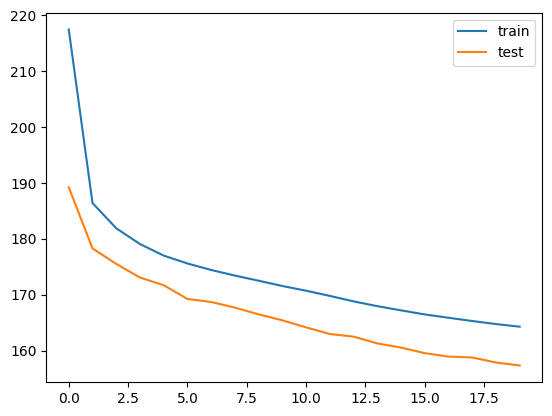

In [88]:
n_epochs = 20
train_key,test_key = random.split(random.PRNGKey(10))
test_loss = []
train_loss = []
for epoch in range(n_epochs):
    print("Epoch: ", epoch)
    key, test_key = random.split(test_key)
    opt_state, nll_train = epoch_step_beta(epoch,
                                           training_generator,
                                           opt_state,
                                           beta)
    nll_test = evaluate_beta(opt_state,
                             test_images,
                             key)
    test_loss.append(nll_test)
    train_loss.append(nll_train)
    print("Train NLL: ", nll_train)
    print("Test NLL: ", nll_test)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.show()

What has changed in the latent space? Try playing with a few values of $\beta$ and explain what affects the change in the latent space?

With a bigger beta our latent space get nearer to the prior. if the beta is too big the latent space will collapse into the prior, and if the beta is too small, the latent space will cover only what is needed to reconstruct the inputs.

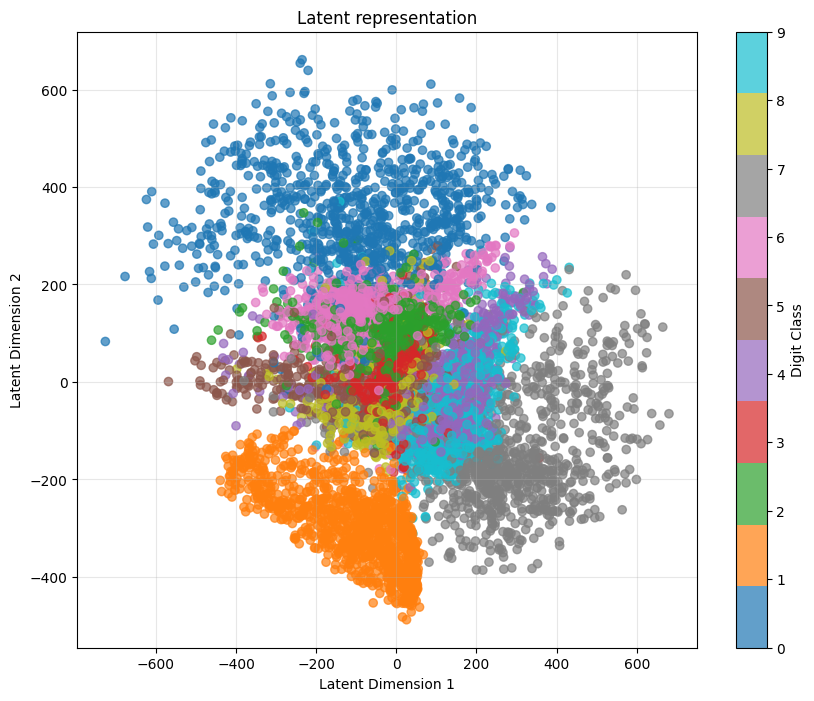

In [89]:
# visualize the latent space
rng = random.PRNGKey(0)
show_latent_space(rng)

What about the reconstruction quality of your model? Has it improved or degraded?

With the right beta=4, the reconstruction is similar, but with a big beta it is worse.

With a small bera the reconstruction is good.

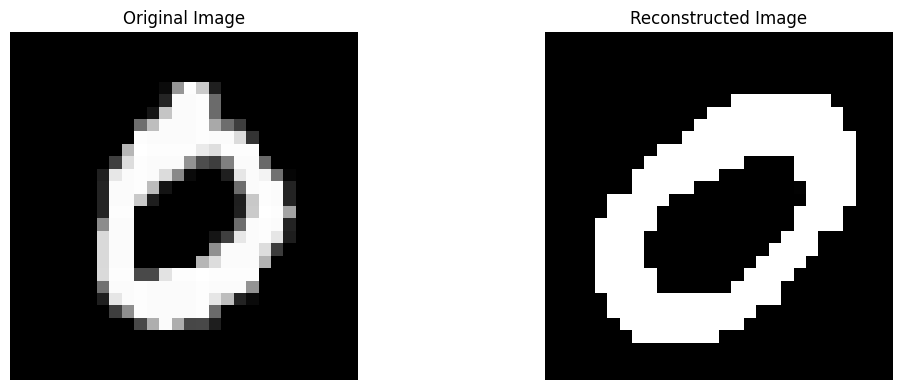

In [92]:
# reconstruct an image
reconstructed = reconstruct_an_image(rng)

Sample from the latent space and decode. Do you see any difference?
noisy samples for very small and very big beta.

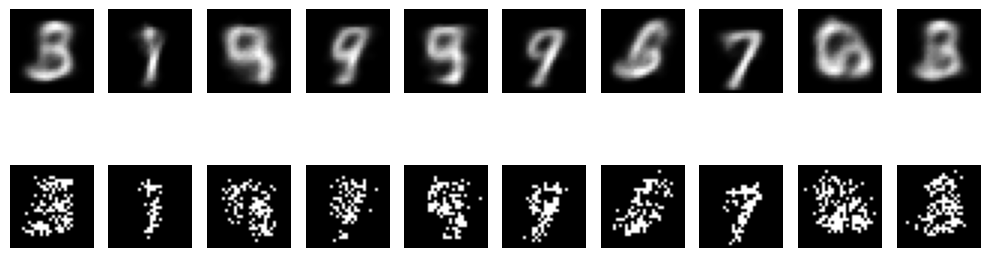

In [100]:
# sample a few images
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 4))
rng = random.PRNGKey(200)

for i in range(10):
    rng, key = random.split(rng)
    sampled_image = sample_image(key,opt_state)

    axes[0, i].imshow(sampled_image.reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')

    rng, key = random.split(rng)
    sampled_bernoulli = random.bernoulli(key, sampled_image)

    axes[1, i].imshow(sampled_bernoulli.reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Importance Weigthed Auto-Encoder (IWAE)


Similarily as for $\beta$-VAE, the distinguishing factor between the VAE and [IWAE](https://arxiv.org/abs/1509.00519) is the alternative objective function, the importance weighted ELBO (IWELBO):

$\mathcal{L}_{K} = \mathbb{E}_{q_\phi(z|x)}\left[\log\frac{1}{K}\sum_k\frac{p_\theta(x|z_k)p(z_k)}{q_\phi(z_k|x)}\right]$.

When computing $\mathcal{L}_{K}$ in contrast to the ELBO, we sample $K$ latent representations instead of one. Although this might seem like a simple extension, the IWELBO has huge implications on the field of VAEs, *as well as* the VI literature in general (see e.g. [Domke and Sheldon](https://arxiv.org/pdf/1808.09034.pdf)). Specifically (n.b., *not an exhaustive list*),

* it is a proper lower-bound on the marginal log-likelihood.
* it is an effective way of improving the NLL test scores (used by state-of-the-art VAEs when reporting NLL scores, including those mentioned above).

The former bullet implies that we *can* use IWELBO to benchmark our VAE against other VAEs, in contrast to the $\beta$-objective. The latter bullet implies that we probably *should* use it when benchmarking. Because, accoring to  Theorem 1 in the IWAE paper, the marginal log-likelihood estimates are montonically increasing with $K$, meaning that

$\mathcal{L}_{K}\geq \mathcal{L}_{K-1}\geq \mathcal{L}$.

### Task 5: IWELBO

Modify the following functions such that $K$ samples are drawn instead of 1. Then compute the IWELBO.

In [101]:
def sample_K(rng, mu, std, K):
  # use the reparameterization trick and sample K latent variables rather than 1
  gaussian = random.normal(rng, shape=(K, mu.shape[0], mu.shape[1]))
  z = mu + gaussian * std
  return z

In [102]:
@partial(jax.jit, static_argnames=['K'])
def forward_K(params, x, rng, K):
    encoder_params, decoder_params = params
    phi = encode(encoder_params, inputs=x)
    z = sample_K(rng,
            mu=phi[0],
            std=phi[1],
            K=K)
    bernoulli_theta = decode(decoder_params, z)
    return phi, z, bernoulli_theta

In [103]:
def get_iw_elbo(params, x, rng, K):
    # the negative elbo should be a scalar value, i.e. averaged over the mini-batch.
    (mu, sigma), z, bernoulli_theta = forward_K(params, x, rng, K)
    # hint: use the logsumexp() operation over K (available in the jax library)
    # and subtract with logK to do the average inside the log.
    sigma = sigma + 1e-6
    p_theta = tfp.distributions.Bernoulli(probs=bernoulli_theta)
    p = tfp.distributions.Normal(loc=jnp.zeros_like(mu), scale=jnp.ones_like(sigma))
    q = tfp.distributions.Normal(loc=mu, scale=sigma)

    p_theta_log = (p_theta.log_prob(x)).sum(-1)
    p_log = (p.log_prob(z)).sum(-1)
    q_log = (q.log_prob(z)).sum(-1)

    elbo = p_theta_log + p_log - q_log

    log_K = jnp.log(K)
    iw_elbo = jnp.mean(jax.scipy.special.logsumexp(elbo, axis=0) - log_K)


    return -iw_elbo

In [104]:
def epoch_step_K(epoch, training_generator, opt_state,beta):
    # an rng, random number generator, is required for all stochastic operations
    rng = random.PRNGKey(epoch)
    nlls = []
    for i, (x, y) in enumerate(tqdm(training_generator)):
        x = jax.device_put(x) / 255
        value, grads = jax.value_and_grad(get_iw_elbo)(get_params(opt_state),
                                                         x,
                                                         rng,
                                                         K)
        opt_state = opt_update(i,
                               grads,
                               opt_state)
        nlls.append(value)
    return opt_state, np.mean(nlls)

In [105]:
def evaluate_K(opt_state, x, test_rng, K):
    params = get_params(opt_state)
    x = jax.device_put(x) / 255.0
    params, x = jax.lax.stop_gradient(params), jax.lax.stop_gradient(x)
    nll = get_iw_elbo(params, x, test_rng, K)
    return nll

Again, we need to re-initialize the network and optimizer states.

In [106]:
K = 6 # try with different values ranging from 1 to 10
latent_dimensions = 2

# encoder defs
encoder_init, encode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    FanOut(2),
    stax.parallel(Dense(latent_dimensions), stax.serial(Dense(latent_dimensions), Softplus)),
)

# decoder defs
decoder_init, decode = stax.serial(
    Dense(300), Relu,
    Dense(300), Relu,
    Dense(28 * 28), Sigmoid
)


# initialize networks and get params
enc_init_key, dec_init_key = random.split(random.PRNGKey(100))
_, encoder_params = encoder_init(enc_init_key, input_shape=(-1, 28 * 28))
_, decoder_params = decoder_init(dec_init_key,
                                 input_shape=
                                 (-1, latent_dimensions))
params = encoder_params, decoder_params

# initialize optimizer
opt_init, opt_update, get_params = optimizers.adam(step_size=0.0001)  # this time we use a smaller learning rate due to numerical stability
opt_state = opt_init(params)

Epoch:  0


100%|██████████| 242/242 [00:35<00:00,  6.88it/s]


Train NLL:  297.81726
Test NLL:  209.38889
Epoch:  1


100%|██████████| 242/242 [00:32<00:00,  7.44it/s]


Train NLL:  203.55307
Test NLL:  196.97874
Epoch:  2


100%|██████████| 242/242 [00:32<00:00,  7.42it/s]


Train NLL:  195.04271
Test NLL:  191.95367
Epoch:  3


100%|██████████| 242/242 [00:33<00:00,  7.33it/s]


Train NLL:  191.07237
Test NLL:  188.90393
Epoch:  4


100%|██████████| 242/242 [00:32<00:00,  7.49it/s]


Train NLL:  188.63927
Test NLL:  187.03975
Epoch:  5


100%|██████████| 242/242 [00:31<00:00,  7.71it/s]


Train NLL:  187.10706
Test NLL:  185.7271
Epoch:  6


100%|██████████| 242/242 [00:32<00:00,  7.53it/s]


Train NLL:  185.96921
Test NLL:  184.72726
Epoch:  7


100%|██████████| 242/242 [00:32<00:00,  7.47it/s]


Train NLL:  185.1127
Test NLL:  183.84813
Epoch:  8


100%|██████████| 242/242 [00:32<00:00,  7.50it/s]


Train NLL:  184.32257
Test NLL:  183.09686
Epoch:  9


100%|██████████| 242/242 [00:32<00:00,  7.44it/s]


Train NLL:  183.64955
Test NLL:  182.32985
Epoch:  10


100%|██████████| 242/242 [00:32<00:00,  7.37it/s]


Train NLL:  182.91562
Test NLL:  181.5381
Epoch:  11


100%|██████████| 242/242 [00:31<00:00,  7.74it/s]


Train NLL:  182.10677
Test NLL:  180.53865
Epoch:  12


100%|██████████| 242/242 [00:32<00:00,  7.47it/s]


Train NLL:  181.04315
Test NLL:  179.24644
Epoch:  13


100%|██████████| 242/242 [00:31<00:00,  7.79it/s]


Train NLL:  179.81912
Test NLL:  177.98557
Epoch:  14


100%|██████████| 242/242 [00:32<00:00,  7.54it/s]


Train NLL:  178.68863
Test NLL:  176.89319
Epoch:  15


100%|██████████| 242/242 [00:31<00:00,  7.62it/s]


Train NLL:  177.70183
Test NLL:  175.97595
Epoch:  16


100%|██████████| 242/242 [00:32<00:00,  7.55it/s]


Train NLL:  176.82494
Test NLL:  175.17743
Epoch:  17


100%|██████████| 242/242 [00:32<00:00,  7.53it/s]


Train NLL:  176.02899
Test NLL:  174.43672
Epoch:  18


100%|██████████| 242/242 [00:31<00:00,  7.69it/s]


Train NLL:  175.31206
Test NLL:  173.74704
Epoch:  19


100%|██████████| 242/242 [00:32<00:00,  7.51it/s]


Train NLL:  174.60176
Test NLL:  173.07465


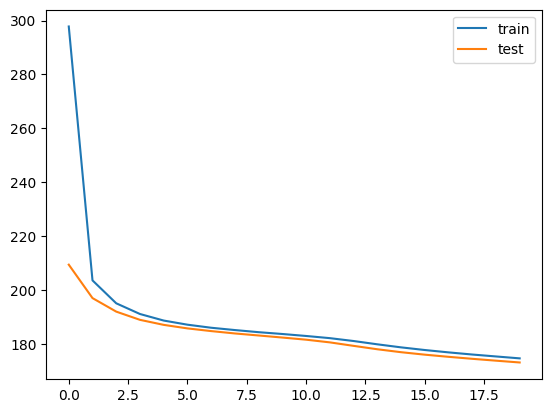

In [107]:
n_epochs = 20
test_key = random.PRNGKey(10)
test_loss = []
train_loss = []
for epoch in range(n_epochs):
    print("Epoch: ", epoch)
    key, test_key = random.split(test_key)
    opt_state, nll_train = epoch_step_K(epoch,
                                      training_generator,
                                      opt_state,
                                      K)
    nll_test = evaluate_K(opt_state, test_images, key, K)
    test_loss.append(nll_test)
    train_loss.append(nll_train)
    print("Train NLL: ", nll_train)
    print("Test NLL: ", nll_test)
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.show()

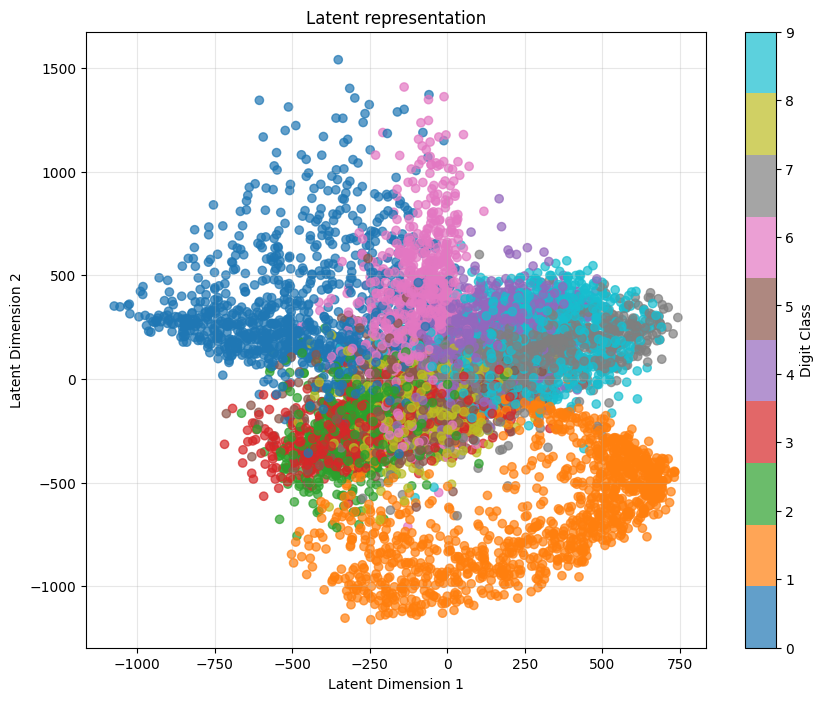

In [108]:
rng = random.PRNGKey(0)
show_latent_space(rng)

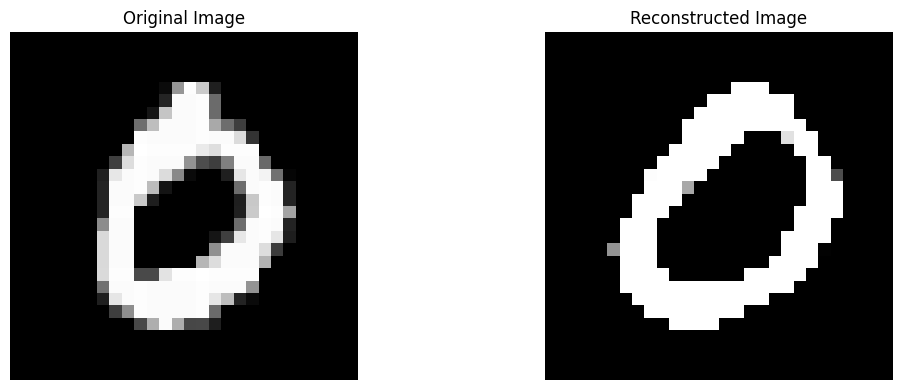

In [109]:
# reconstruct an image
reconstructed = reconstruct_an_image(rng)

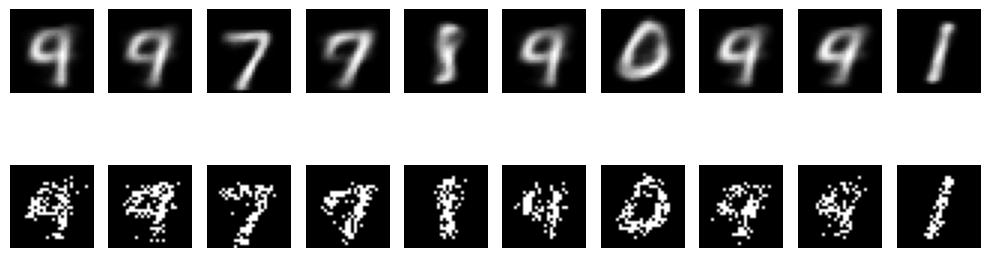

In [110]:
# sample a few images
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 4))
rng = random.PRNGKey(500)

for i in range(10):
    rng, key = random.split(rng)
    sampled_image = sample_image(key,opt_state)

    axes[0, i].imshow(sampled_image.reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')

    rng, key = random.split(rng)
    sampled_bernoulli = random.bernoulli(key, sampled_image)

    axes[1, i].imshow(sampled_bernoulli.reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Plot your NLL test scores as a function of $K$ for $K \in \{1,\dots,10\}$, and see if there is any improvement in NLL as K increases.

**Saved scores forK from 1 to 10:**
1. 174.39197
2. 173.4412
3.
4. 173.75374
5.
6. 172.97897
7.
8. 171.73238
9.
10. 171.25491




In [ ]:
scores = [174.39197,173.4412, 173.75374, 172.97897, 171.73238, 171.25491]

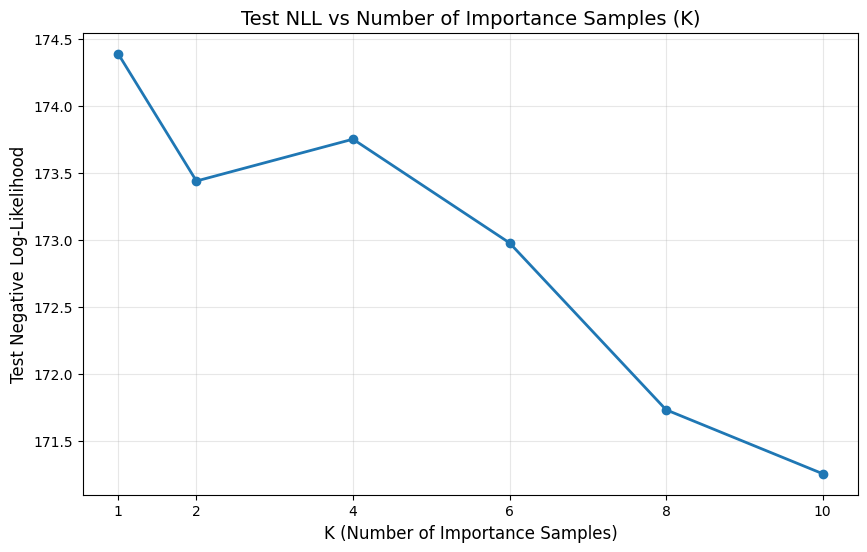

In [ ]:
def plot_test_nll_vs_k():
    K_values = [1, 2, 4, 6, 8, 10]
    plt.figure(figsize=(10, 6))
    plt.plot(K_values, scores, marker='o', linewidth=2, markersize=6)
    plt.xlabel('K (Number of Importance Samples)', fontsize=12)
    plt.ylabel('Test Negative Log-Likelihood', fontsize=12)
    plt.title('Test NLL vs Number of Importance Samples (K)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xticks(K_values)


    plt.show()
plot_test_nll_vs_k()

Finally, it is valuable to know, how long did it take you to finish this practical?[4]